<a href="https://colab.research.google.com/github/Johnyeyu/Bike/blob/main/MIS_536_Team_Supreme_Bike_Crash_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS 536 Team Supreme Bike Crash Analysis

##**STEP 1. Importing required libraries**

In [ ]:
!pip install dmba
!pip install matplotlib
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,make_scorer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from dmba import plotDecisionTree

##**STEP 2. Load, clean and prepare data**

###**2.1 Load the data**

In [ ]:
#Load the data
bike=pd.read_csv("https://raw.githubusercontent.com/Johnyeyu/Bike/main/NCDOT_BikePedCrash.csv")
bike


,X,Y,OBJECTID_1,AmbulanceR,BikeAge,BikeAgeGrp,BikeAlcDrg,BikeAlcFlg,BikeDir,BikeInjury,BikePos,BikeRace,BikeSex,City,County,CrashAlcoh,CrashDay,CrashGrp,CrashHour,CrashID,CrashLoc,CrashMonth,CrashSevr,CrashType,CrashYear,Developmen,DrvrAge,DrvrAgeGrp,DrvrAlcDrg,DrvrAlcFlg,DrvrInjury,DrvrRace,DrvrSex,DrvrVehTyp,HitRun,Latitude,LightCond,Locality,Longitude,NumBicsAin,NumBicsBin,NumBicsCin,NumBicsKil,NumBicsNoi,NumBicsTot,NumBicsUin,NumLanes,NumUnits,RdCharacte,RdClass,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,Region,RuralUrban,SpeedLimit,TraffCntrl,Weather,Workzone,OBJECTID
0,-78.883896,36.039490,1,Yes,11,11-15,.,No,With Traffic,B: Suspected Minor Injury,Sidewalk / Crosswalk / Driveway Crossing,Black,Male,Durham,Durham,No,Tuesday,Parallel Paths - Other Circumstances,16,101878313,Non-Intersection,January,B: Suspected Minor Injury,Bicyclist Ride Out - Parallel Path,2007,Residential,35,30-39,.,No,O: No Injury,White,Male,Passenger Car,No,36.039490,Daylight,Urban (>70% Developed),-78.883896,.,.,.,.,.,.,.,1 lane,2,Straight - Level,Local Street,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,No Control Present,Clear,No,1
1,-78.782800,35.751118,2,Yes,20,20-24,.,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,Hispanic,Male,Cary,Wake,No,Friday,Motorist Failed to Yield - Signalized Intersec...,9,101885911,Intersection,January,C: Possible Injury,Motorist Drive Out - Right Turn on Red,2007,Residential,64,60-69,.,No,O: No Injury,White,Male,Passenger Car,No,35.751118,Daylight,Urban (>70% Developed),-78.782800,.,.,.,.,.,.,.,3 lanes,2,Straight - Grade,Local Street,Dry,"Two-Way, Divided, Unprotected Median",None,Four-Way Intersection,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,Stop And Go Signal,Clear,No,2
2,-80.697820,35.084732,3,Yes,37,30-39,.,No,Unknown,B: Suspected Minor Injury,Non-Roadway,Black,Male,Stallings,Union,No,Monday,Non-Roadway,17,101886055,Non-Roadway,January,B: Suspected Minor Injury,Non-Roadway,2007,Commercial,39,30-39,.,No,O: No Injury,White,Female,Passenger Car,No,35.084732,Dusk,Urban (>70% Developed),-80.697820,.,.,.,.,.,.,.,2 lanes,2,Straight - Level,Public Vehicular Area,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Piedmont,Urban,20 - 25 MPH,No Control Present,Cloudy,No,3
3,-80.479320,35.684400,4,Yes,30,30-39,.,No,With Traffic,C: Possible Injury,Travel Lane,White,Male,Salisbury,Rowan,No,Friday,Motorist Left Turn / Merge,17,101890155,Intersection,January,C: Possible Injury,Motorist Left Turn - Opposite Direction,2007,Commercial,999,Unknown,.,No,Unknown Injury,Unknown/Missing,Unknown,Sport Utility,Yes,35.684400,Daylight,Urban (>70% Developed),-80.479320,.,.,.,.,.,.,.,2 lanes,2,Straight - Grade,Local Street,Dry,"Two-Way, Not Divided",None,Four-Way Intersection,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,No Control Present,Cloudy,No,4
4,-78.904450,34.999428,5,Yes,45,40-49,.,No,With Traffic,B: Suspected Minor Injury,Travel Lane,Black,Male,Fayetteville,Cumberland,No,Friday,Motorist Overtaking Bicyclist,12,101899756,Non-Intersection,January,B: Suspected Minor Injury,Motorist Overtaking - Bicyclist Swerved,2007,Commercial,51,50-59,.,No,O: No Injury,Black,Female,Van,No,34.999428,Daylight,Urban (>70% Developed),-78.904450,.,.,.,.,.,.,.,2 lanes,2,Straight - Level,Local Street,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Coastal,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear,No,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,-77.049010,35.108281,12169,No,54,50-59,No,No,Facing Traffic,O: No Injury,Travel Lane,Black,Male,New Bern,Craven,No,Saturday,Motorist Failed to Yield - Signalized Intersec...,15,106155866,Intersection,November,O: No Injury,Motorist Drive Out - Signalized Inter

###**2.2 Explore the Data**

In [ ]:
print(bike.head())
print(bike.columns)
print(bike.describe())
print(bike.info())


           X          Y  OBJECTID_1  ... Weather Workzone OBJECTID
0 -78.883896  36.039490           1  ...   Clear       No        1
1 -78.782800  35.751118           2  ...   Clear       No        2
2 -80.697820  35.084732           3  ...  Cloudy       No        3
3 -80.479320  35.684400           4  ...  Cloudy       No        4
4 -78.904450  34.999428           5  ...   Clear       No        5

[5 rows x 62 columns]
Index(['X', 'Y', 'OBJECTID_1', 'AmbulanceR', 'BikeAge', 'BikeAgeGrp',
       'BikeAlcDrg', 'BikeAlcFlg', 'BikeDir', 'BikeInjury', 'BikePos',
       'BikeRace', 'BikeSex', 'City', 'County', 'CrashAlcoh', 'CrashDay',
       'CrashGrp', 'CrashHour', 'CrashID', 'CrashLoc', 'CrashMonth',
       'CrashSevr', 'CrashType', 'CrashYear', 'Developmen', 'DrvrAge',
       'DrvrAgeGrp', 'DrvrAlcDrg', 'DrvrAlcFlg', 'DrvrInjury', 'DrvrRace',
       'DrvrSex', 'DrvrVehTyp', 'HitRun', 'Latitude', 'LightCond', 'Locality',
       'Longitude', 'NumBicsAin', 'NumBicsBin', 'NumBicsCin', 'Num

### **2.3 Data Visualization**

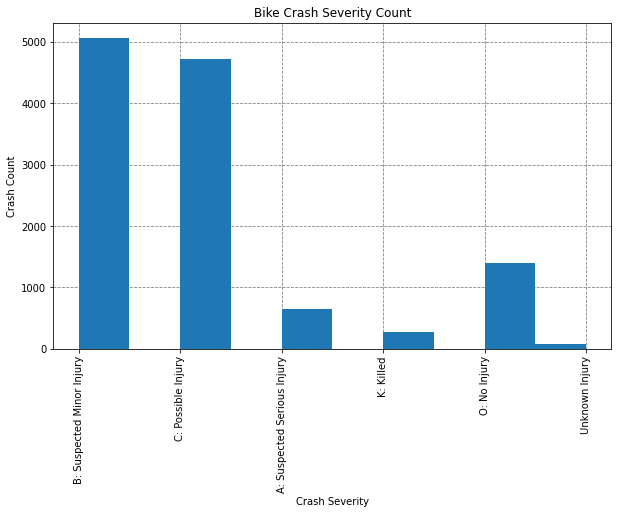

In [ ]:
#Bike Crash Severity Count
plt.figure(figsize=(10,6))
ax = bike.CrashSevr.hist()
ax.set_xlabel('Crash Severity')
ax.set_ylabel('Crash Count')
ax.set_title('Bike Crash Severity Count')
plt.xticks(rotation=90)
ax.set_axisbelow(True) 
ax.grid(which='major', color='grey', linestyle='--')
plt.show()

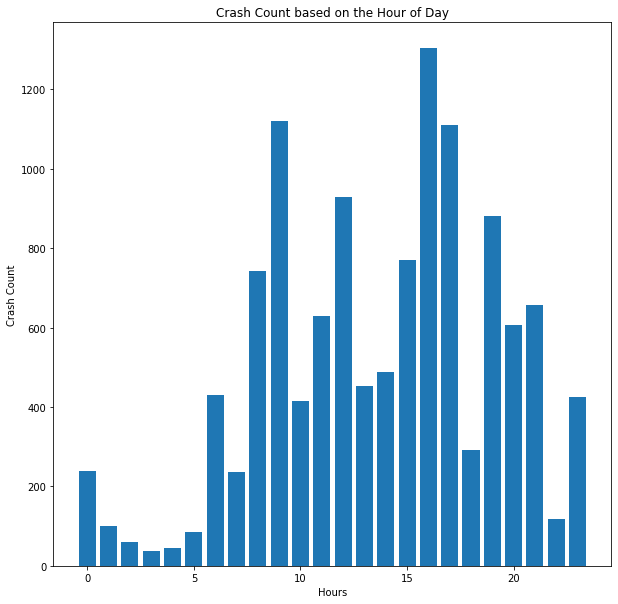

In [ ]:
#Plot crash count based on the hour of day
y = bike['CrashHour'].value_counts()
x = bike['CrashHour'].unique()
fig = plt.figure(figsize=(10,10))
plt.bar(x, y,)
plt.title('Crash Count based on the Hour of Day')
plt.xlabel('Hours')
plt.ylabel('Crash Count');

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

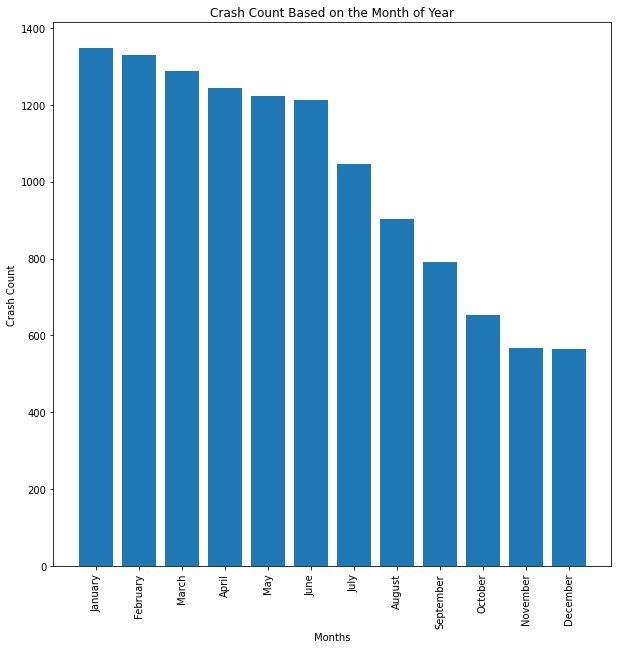

In [ ]:
#Plot Crash Count Based on the Month of Year
y = bike['CrashMonth'].value_counts()
x = bike['CrashMonth'].unique()
fig = plt.figure(figsize=(10,10))

plt.bar(x, y)
plt.title('Crash Count Based on the Month of Year')
plt.xlabel('Months')
plt.ylabel('Crash Count')
plt.xticks(rotation=90)

### **2.4 Drop Columns as They Are Not Significant for Prediction**

In [ ]:
# Dropping the unnecessary columns that does not add value to our analysis
bike.drop(['X','Y','OBJECTID_1','BikeAlcDrg','BikeAgeGrp','CrashID','DrvrAgeGrp','NumBicsAin',
          'NumBicsBin','NumBicsCin','NumBicsKil','NumBicsNoi','NumBicsTot','NumBicsUin',
           'DrvrAlcDrg','Workzone','Locality','NumUnits','BikeRace','BikeSex','DrvrRace','DrvrSex','Latitude','Longitude',
           'City','County','OBJECTID'],axis=1,inplace=True)
bike.head()

,AmbulanceR,BikeAge,BikeAlcFlg,BikeDir,BikeInjury,BikePos,CrashAlcoh,CrashDay,CrashGrp,CrashHour,CrashLoc,CrashMonth,CrashSevr,CrashType,CrashYear,Developmen,DrvrAge,DrvrAlcFlg,DrvrInjury,DrvrVehTyp,HitRun,LightCond,NumLanes,RdCharacte,RdClass,RdConditio,RdConfig,RdDefects,RdFeature,RdSurface,Region,RuralUrban,SpeedLimit,TraffCntrl,Weather
0,Yes,11,No,With Traffic,B: Suspected Minor Injury,Sidewalk / Crosswalk / Driveway Crossing,No,Tuesday,Parallel Paths - Other Circumstances,16,Non-Intersection,January,B: Suspected Minor Injury,Bicyclist Ride Out - Parallel Path,2007,Residential,35,No,O: No Injury,Passenger Car,No,Daylight,1 lane,Straight - Level,Local Street,Dry,"Two-Way, Divided, Unprotected Median",None,No Special Feature,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,No Control Present,Clear
1,Yes,20,No,Facing Traffic,C: Possible Injury,Sidewalk / Crosswalk / Driveway Crossing,No,Friday,Motorist Failed to Yield - Signalized Intersec...,9,Intersection,January,C: Possible Injury,Motorist Drive Out - Right Turn on Red,2007,Residential,64,No,O: No Injury,Passenger Car,No,Daylight,3 lanes,Straight - Grade,Local Street,Dry,"Two-Way, Divided, Unprotected Median",None,Four-Way Intersection,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,Stop And Go Signal,Clear
2,Yes,37,No,Unknown,B: Suspected Minor Injury,Non-Roadway,No,Monday,Non-Roadway,17,Non-Roadway,January,B: Suspected Minor Injury,Non-Roadway,2007,Commercial,39,No,O: No Injury,Passenger Car,No,Dusk,2 lanes,Straight - Level,Public Vehicular Area,Dry,"Two-Way, Not Divided",None,No Special Feature,Smooth Asphalt,Piedmont,Urban,20 - 25 MPH,No Control Present,Cloudy
3,Yes,30,No,With Traffic,C: Possible Injury,Travel Lane,No,Friday,Motorist Left Turn / Merge,17,Intersection,January,C: Possible Injury,Motorist Left Turn - Opposite Direction,2007,Commercial,999,No,Unknown Injury,Sport Utility,Yes,Daylight,2 lanes,Straight - Grade,Local Street,Dry,"Two-Way, Not Divided",None,Four-Way Intersection,Smooth Asphalt,Piedmont,Urban,30 - 35 MPH,No Control Present,Cloudy
4,Yes,45,No,With Traffic,B: Suspected Minor Injury,Travel Lane,No,Friday,Motorist Overtaking Bicyclist,12,Non-Intersection,January,B: Suspected Minor Injury,Motorist Overtaking - Bicyclist Swerved,2007,Commercial,51,No,O: No Injury,Van,No,Daylight,2 lanes,Straight - Level,Local Street,Dry,"Two-Way, Not Divided",None,No Special Feature,Coarse Asphalt,Coastal,Urban,30 - 35 MPH,"Double Yellow Line, No Passing Zone",Clear


###**2.5 Create Dummy, Encode, Clean, and Merge the Data**

In [ ]:
#Transform categorical predictors to Dummy Variables 
dummy_df=pd.get_dummies(bike, columns=['CrashLoc','CrashType','BikeDir','BikePos','CrashGrp','CrashType','Developmen','DrvrVehTyp','LightCond','RdCharacte',
       'RdClass','RdConditio','RdConfig','RdFeature','RdSurface',
       'Region','RuralUrban','TraffCntrl','RdDefects','Weather','BikeInjury','DrvrInjury'],prefix_sep='_',drop_first=False)
dummy_df.drop(columns=['BikeAlcFlg','CrashAlcoh','CrashDay','CrashMonth','CrashSevr','DrvrAlcFlg','SpeedLimit','HitRun','CrashSevr','NumLanes','AmbulanceR','BikeAge','CrashHour', 'DrvrAge','CrashYear'],inplace=True)
dummy_df

,CrashLoc_Intersection,CrashLoc_Intersection-Related,CrashLoc_Non-Intersection,CrashLoc_Non-Roadway,CrashLoc_Unknown Location,CrashType_Backing Vehicle,CrashType_Bicycle Only,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Other / Unknown,"CrashType_Bicyclist Lost Control - Oversteering, Improper Braking, Speed",CrashType_Bicyclist Lost Control - Surface Conditions,CrashType_Bicyclist Overtaking - Extended Door,CrashType_Bicyclist Overtaking - Other / Unknown,CrashType_Bicyclist Overtaking - Parked Vehicle,CrashType_Bicyclist Overtaking - Passing on Left,CrashType_Bicyclist Overtaking - Passing on Right,CrashType_Bicyclist Ride Out - Commercial Driveway / Alley,CrashType_Bicyclist Ride Out - Midblock - Unknown,CrashType_Bicyclist Ride Out - Other Midblock,CrashType_Bicyclist Ride Out - Parallel Path,CrashType_Bicyclist Ride Out - Residential Driveway,CrashType_Bicyclist Ride Out - Sign-Controlled Intersection,CrashType_Bicyclist Ride Out - Signalized Intersection,CrashType_Bicyclist Ride Out - Signalized Intersection,CrashType_Bicyclist Ride Through - Sign-Controlled Intersection,CrashType_Bicyclist Ride Through - Signalized Intersection,CrashType_Bicyclist Right Turn - Opposite Direction,CrashType_Bicyclist Right Turn - Same Direction,CrashType_Bicyclist Turning Error - Left Turn,CrashType_Bicyclist Turning Error - Other,CrashType_Bicyclist Turning Error - Right Turn,CrashType_Crossing Paths - Intersection - Other / Unknown,CrashType_Crossing Paths - Midblock - Other / Unknown,...,TraffCntrl_Missing,TraffCntrl_No Control Present,TraffCntrl_Other,TraffCntrl_RR Gate And Flasher,TraffCntrl_School Zone Signs,TraffCntrl_Stop And Go Signal,TraffCntrl_Stop Sign,TraffCntrl_Warning Sign,TraffCntrl_Yield Sign,RdDefects_Debris,RdDefects_Missing,RdDefects_No Shoulders,RdDefects_Non-Highway Work,RdDefects_None,RdDefects_Obstruction In Roadway,RdDefects_Other,RdDefects_Road Surface Condition,"RdDefects_Rut, Holes, Bumps","RdDefects_Shoulders Low, Soft Or High","RdDefects_Traffic Control Device Inoperative, Not Visible Or Missing",RdDefects_Unknown,RdDefects_Work Zone,Weather_Clear,Weather_Cloudy,"Weather_Fog, Smog, Smoke",Weather_Other,Weather_Rain,"Weather_Snow, Sleet, Hail, Freezing Rain/Drizzle",BikeInjury_A: Suspected Serious Injury,BikeInjury_B: Suspected Minor Injury,BikeInjury_C: Possible Injury,BikeInjury_K: Killed,BikeInjury_O: No Injury,BikeInjury_Unknown Injury,DrvrInjury_A: Suspected Serious Injury,DrvrInjury_B: Suspected Minor Injury,DrvrInjury_C: Possible Injury,DrvrInjury_K: Killed,DrvrInjury_O: No Injury,DrvrInjury_Unknown Injury
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
#Encode the categorical data
text_col = ['BikeAlcFlg','CrashAlcoh','CrashDay','CrashMonth','CrashSevr','DrvrAlcFlg','SpeedLimit','HitRun','CrashSevr','NumLanes','AmbulanceR']
en_bike = pd.DataFrame()
for col in text_col:
    encoder = LabelEncoder()
    en_bike[col] = encoder.fit_transform(bike[col])
  
en_bike

,BikeAlcFlg,CrashAlcoh,CrashDay,CrashMonth,CrashSevr,DrvrAlcFlg,SpeedLimit,HitRun,NumLanes,AmbulanceR
0,1,0,5,4,1,1,1,0,0,1
1,1,0,0,4,2,1,1,0,2,1
2,1,0,1,4,1,1,0,0,1,1
3,1,0,0,4,2,1,1,1,1,1
4,1,0,0,4,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
12168,1,0,2,9,4,1,3,0,1,0
12169,1,0,3,2,4,1,1,0,1,0
12170,1,0,1,2,2,1,1,0,1,1
12171,1,0,0,2,1,1,4,0,1,1


In [ ]:
# Extract columns that does not have categorical value
no_en_df = ['BikeAge','CrashHour', 'DrvrAge','CrashYear']
no_en_df = pd.DataFrame(bike[no_en_df])
no_en_df

,BikeAge,CrashHour,DrvrAge,CrashYear
0,11,16,35,2007
1,20,9,64,2007
2,37,17,39,2007
3,30,17,999,2007
4,45,12,51,2007
...,...,...,...,...
12168,54,15,23,2019
12169,38,16,45,2019
12170,8,15,47,2019
12171,65,15,82,2019


In [ ]:
# Convert BikeAge 999 and unknown into median, Also replace 70+ to 70
bike['BikeAge'] = bike['BikeAge'].replace(['70+'],70)
bike['BikeAge'] = bike['BikeAge'].replace(['Unknown'],None)
biker_medians=bike['BikeAge'].median()
bike['BikeAge']= bike['BikeAge'].fillna(value=biker_medians)
bike['BikeAge']= bike['BikeAge'].replace(['999'],biker_medians)
bike['BikeAge']=bike['BikeAge'].astype(float)
bike['BikeAge'].unique()

array([11., 20., 37., 30., 45., 58., 51., 13., 18., 39., 19., 35., 40.,
       31., 10., 49.,  6., 54., 33.,  8., 60., 21., 42., 50., 12., 14.,
       17., 28., 47., 22., 46., 32., 36., 29., 52., 16., 38., 23., 15.,
        7.,  5., 34., 48., 53., 55., 61., 65., 56., 44., 41., 64., 70.,
       62., 25., 43.,  9., 26., 59., 24., 68., 57., 27., 66.,  4., 63.,
       69.,  3., 67.,  0.,  1., 82., 79., 76., 73.,  2., 81., 72., 83.,
       71., 75., 74., 78., 80., 84., 77., 91., 90., 87., 93., 88., 89.])

In [ ]:
# Convert DrvrAge 999 and unknown into median. Also replace 70+ to 70
bike['DrvrAge'] = bike['DrvrAge'].replace(['70+'],70)
bike['DrvrAge'] = bike['DrvrAge'].replace(['Unknown'],None)
driver_medians=bike['DrvrAge'].median()
bike['DrvrAge']= bike['DrvrAge'].fillna(value=driver_medians)
bike['DrvrAge']= bike['DrvrAge'].replace(['999'],driver_medians)
bike['DrvrAge']=bike['DrvrAge'].astype(float)
bike['DrvrAge'].unique()

array([35., 64., 39., 45., 51., 61., 18., 70., 24., 27., 21., 17., 66.,
       47., 26., 29., 19., 46., 67., 25., 34., 28., 23., 52., 33., 37.,
       44., 40., 58., 16., 49., 20., 53., 38., 43., 32., 36., 50., 30.,
       54., 63., 56., 48., 55., 57., 41., 22., 42., 65., 59., 69., 31.,
       60., 62., 68., 12.,  9., 15., 14., 81., 75., 71., 76., 79., 87.,
       72., 82., 77., 80., 85., 78., 83., 74., 13., 73., 90., 86., 89.,
       88., 84., 92., 96., 91., 93., 94., 99., 97.])

In [ ]:
# Extract columns that does not have categorical value
no_en_df = ['BikeAge','CrashHour', 'DrvrAge','CrashYear']
no_en_df = pd.DataFrame(bike[no_en_df])
no_en_df

,BikeAge,CrashHour,DrvrAge,CrashYear
0,11.0,16,35.0,2007
1,20.0,9,64.0,2007
2,37.0,17,39.0,2007
3,30.0,17,45.0,2007
4,45.0,12,51.0,2007
...,...,...,...,...
12168,54.0,15,23.0,2019
12169,38.0,16,45.0,2019
12170,8.0,15,47.0,2019
12171,65.0,15,82.0,2019


In [ ]:
bike_df = pd.concat([en_bike, no_en_df,dummy_df],axis=1,sort=False)
bike_df

,BikeAlcFlg,CrashAlcoh,CrashDay,CrashMonth,CrashSevr,DrvrAlcFlg,SpeedLimit,HitRun,NumLanes,AmbulanceR,BikeAge,CrashHour,DrvrAge,CrashYear,CrashLoc_Intersection,CrashLoc_Intersection-Related,CrashLoc_Non-Intersection,CrashLoc_Non-Roadway,CrashLoc_Unknown Location,CrashType_Backing Vehicle,CrashType_Bicycle Only,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Other / Unknown,"CrashType_Bicyclist Lost Control - Oversteering, Improper Braking, Speed",CrashType_Bicyclist Lost Control - Surface Conditions,CrashType_Bicyclist Overtaking - Extended Door,CrashType_Bicyclist Overtaking - Other / Unknown,CrashType_Bicyclist Overtaking - Parked Vehicle,CrashType_Bicyclist Overtaking - Passing on Left,CrashType_Bicyclist Overtaking - Passing on Right,CrashType_Bicyclist Ride Out - Commercial Driveway / Alley,CrashType_Bicyclist Ride Out - Midblock - Unknown,CrashType_Bicyclist Ride Out - Other Midblock,...,TraffCntrl_Missing,TraffCntrl_No Control Present,TraffCntrl_Other,TraffCntrl_RR Gate And Flasher,TraffCntrl_School Zone Signs,TraffCntrl_Stop And Go Signal,TraffCntrl_Stop Sign,TraffCntrl_Warning Sign,TraffCntrl_Yield Sign,RdDefects_Debris,RdDefects_Missing,RdDefects_No Shoulders,RdDefects_Non-Highway Work,RdDefects_None,RdDefects_Obstruction In Roadway,RdDefects_Other,RdDefects_Road Surface Condition,"RdDefects_Rut, Holes, Bumps","RdDefects_Shoulders Low, Soft Or High","RdDefects_Traffic Control Device Inoperative, Not Visible Or Missing",RdDefects_Unknown,RdDefects_Work Zone,Weather_Clear,Weather_Cloudy,"Weather_Fog, Smog, Smoke",Weather_Other,Weather_Rain,"Weather_Snow, Sleet, Hail, Freezing Rain/Drizzle",BikeInjury_A: Suspected Serious Injury,BikeInjury_B: Suspected Minor Injury,BikeInjury_C: Possible Injury,BikeInjury_K: Killed,BikeInjury_O: No Injury,BikeInjury_Unknown Injury,DrvrInjury_A: Suspected Serious Injury,DrvrInjury_B: Suspected Minor Injury,DrvrInjury_C: Possible Injury,DrvrInjury_K: Killed,DrvrInjury_O: No Injury,DrvrInjury_Unknown Injury
0,1,0,5,4,1,1,1,0,0,1,11.0,16,35.0,2007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,1,0,0,4,2,1,1,0,2,1,20.0,9,64.0,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,1,0,1,4,1,1,0,0,1,1,37.0,17,39.0,2007,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,1,0,0,4,2,1,1,1,1,1,30.0,17,45.0,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,1,0,0,4,1,1,1,0,1,1,45.0,12,51.0,2007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12168,1,0,2,9,4,1,3,0,1,0,54.0,15,23.0,2019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
12169,1,0,3,2,4,1,1,0,1,0,38.0,16,45.0,2019,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
12170,1,0,1,2,2,1,1,0,1,1,8.0,15,47.0,2019,0,0,1,0,0,0,0,0,0,0,0,0

##**STEP 3. Split Data Into Training and Validation Sets**

###**3.1 Construct Dataset for Analysis**

In [ ]:
# construct datasets for analysis
target = 'CrashSevr'
predictors = list(bike_df)
predictors.remove(target)
X = bike_df[predictors]
y = bike_df[target]
print(X)
print(y)

       BikeAlcFlg  ...  DrvrInjury_Unknown Injury
0               1  ...                          0
1               1  ...                          0
2               1  ...                          0
3               1  ...                          1
4               1  ...                          0
...           ...  ...                        ...
12168           1  ...                          0
12169           1  ...                          0
12170           1  ...                          0
12171           1  ...                          0
12172           1  ...                          1

[12173 rows x 527 columns]
0        1
1        2
2        1
3        2
4        1
        ..
12168    4
12169    4
12170    2
12171    1
12172    1
Name: CrashSevr, Length: 12173, dtype: int64


###**3.2 Partition the Data Into Training (70%) and Validation (30%) Sets**

In [ ]:
# create the training set and the test set 
train_X, valid_X, train_y, valid_y = train_test_split(X,y, test_size=0.3, random_state=1)
train_X
valid_X

,BikeAlcFlg,CrashAlcoh,CrashDay,CrashMonth,DrvrAlcFlg,SpeedLimit,HitRun,NumLanes,AmbulanceR,BikeAge,CrashHour,DrvrAge,CrashYear,CrashLoc_Intersection,CrashLoc_Intersection-Related,CrashLoc_Non-Intersection,CrashLoc_Non-Roadway,CrashLoc_Unknown Location,CrashType_Backing Vehicle,CrashType_Backing Vehicle,CrashType_Bicycle Only,CrashType_Bicycle Only,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Other / Unknown,CrashType_Bicyclist Lost Control - Other / Unknown,...,TraffCntrl_Missing,TraffCntrl_No Control Present,TraffCntrl_Other,TraffCntrl_RR Gate And Flasher,TraffCntrl_School Zone Signs,TraffCntrl_Stop And Go Signal,TraffCntrl_Stop Sign,TraffCntrl_Warning Sign,TraffCntrl_Yield Sign,RdDefects_Debris,RdDefects_Missing,RdDefects_No Shoulders,RdDefects_Non-Highway Work,RdDefects_None,RdDefects_Obstruction In Roadway,RdDefects_Other,RdDefects_Road Surface Condition,"RdDefects_Rut, Holes, Bumps","RdDefects_Shoulders Low, Soft Or High","RdDefects_Traffic Control Device Inoperative, Not Visible Or Missing",RdDefects_Unknown,RdDefects_Work Zone,Weather_Clear,Weather_Cloudy,"Weather_Fog, Smog, Smoke",Weather_Other,Weather_Rain,"Weather_Snow, Sleet, Hail, Freezing Rain/Drizzle",BikeInjury_A: Suspected Serious Injury,BikeInjury_B: Suspected Minor Injury,BikeInjury_C: Possible Injury,BikeInjury_K: Killed,BikeInjury_O: No Injury,BikeInjury_Unknown Injury,DrvrInjury_A: Suspected Serious Injury,DrvrInjury_B: Suspected Minor Injury,DrvrInjury_C: Possible Injury,DrvrInjury_K: Killed,DrvrInjury_O: No Injury,DrvrInjury_Unknown Injury
6458,1,0,5,10,1,1,0,3,1,54.0,10,46.0,2013,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
9446,1,0,4,5,1,2,0,1,1,43.0,19,41.0,2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
600,1,0,3,5,1,3,0,9,1,42.0,9,40.0,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8483,1,0,5,5,1,1,0,5,0,44.0,6,66.0,2014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8502,1,0,4,1,1,2,0,1,0,29.0,20,42.0,2014,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1,0,6,3,1,2,1,1,0,45.0,17,45.0,2007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
5385,1,0,2,11,1,6,0,1,0,49.0,9,48.0,2012,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5393,0,0,0,11,1,1,0,3,1,26.0,13,87.0,2012,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

##**STEP 4 Naive Bayes**

###**4.1 Create a Multinomial Classifier Model**

In [ ]:
mnNB = MultinomialNB()
mnNB.fit(train_X, train_y)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

###**4.2 Test Classifier for Validation Dataset**

In [ ]:
# To predict the classification for test dataset
y_predict = mnNB.predict(valid_X)
y_predProb = mnNB.predict_proba(valid_X)
print("Prediction:", y_predict, "Probability:", y_predProb)

# To append prediction, predicted probability to the testing dataset and print the new dataset out using print()
results = pd.concat([valid_X, pd.DataFrame(y_predProb, index=valid_X.index)], axis=1)
results = pd.concat([results, pd.DataFrame(y_predict, index=results.index, columns=['Predicted'])], axis=1)
results = pd.concat([results, pd.DataFrame(valid_y, index=results.index)], axis=1)

# For better visibility changed the name of MAX_SEV_IR to Actual
results = results.rename(columns = {"CrashSevr":"Actual"}) 

# To view prediction, observed outcome, and predictors for each data point side by side
results

Prediction: [2 0 1 ... 1 4 2] Probability: [[1.26507498e-07 5.06295280e-05 9.99908015e-01 7.25918083e-09
  4.12212725e-05 3.72314883e-10]
 [5.96046640e-01 1.99251410e-02 1.79054849e-01 2.04968034e-01
  5.33554843e-06 8.77927618e-10]
 [1.67145171e-07 9.88080938e-01 1.11414459e-02 6.99925716e-10
  7.77448008e-04 5.98686521e-10]
 ...
 [5.52473727e-06 9.99869558e-01 1.16007494e-04 1.18749506e-10
  8.90933825e-06 4.88898015e-12]
 [1.23663292e-05 1.46687763e-03 3.91381418e-02 3.35660331e-07
  9.59303282e-01 7.89963922e-05]
 [3.27646017e-05 2.21776263e-03 9.94147391e-01 2.50669696e-06
  3.59957364e-03 1.72941076e-09]]


,BikeAlcFlg,CrashAlcoh,CrashDay,CrashMonth,DrvrAlcFlg,SpeedLimit,HitRun,NumLanes,AmbulanceR,BikeAge,CrashHour,DrvrAge,CrashYear,CrashLoc_Intersection,CrashLoc_Intersection-Related,CrashLoc_Non-Intersection,CrashLoc_Non-Roadway,CrashLoc_Unknown Location,CrashType_Backing Vehicle,CrashType_Backing Vehicle,CrashType_Bicycle Only,CrashType_Bicycle Only,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Other / Unknown,CrashType_Bicyclist Lost Control - Other / Unknown,...,TraffCntrl_Yield Sign,RdDefects_Debris,RdDefects_Missing,RdDefects_No Shoulders,RdDefects_Non-Highway Work,RdDefects_None,RdDefects_Obstruction In Roadway,RdDefects_Other,RdDefects_Road Surface Condition,"RdDefects_Rut, Holes, Bumps","RdDefects_Shoulders Low, Soft Or High","RdDefects_Traffic Control Device Inoperative, Not Visible Or Missing",RdDefects_Unknown,RdDefects_Work Zone,Weather_Clear,Weather_Cloudy,"Weather_Fog, Smog, Smoke",Weather_Other,Weather_Rain,"Weather_Snow, Sleet, Hail, Freezing Rain/Drizzle",BikeInjury_A: Suspected Serious Injury,BikeInjury_B: Suspected Minor Injury,BikeInjury_C: Possible Injury,BikeInjury_K: Killed,BikeInjury_O: No Injury,BikeInjury_Unknown Injury,DrvrInjury_A: Suspected Serious Injury,DrvrInjury_B: Suspected Minor Injury,DrvrInjury_C: Possible Injury,DrvrInjury_K: Killed,DrvrInjury_O: No Injury,DrvrInjury_Unknown Injury,0,1,2,3,4,5,Predicted,Actual
6458,1,0,5,10,1,1,0,3,1,54.0,10,46.0,2013,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1.265075e-07,0.000051,0.999908,7.259181e-09,0.000041,3.723149e-10,2,2
9446,1,0,4,5,1,2,0,1,1,43.0,19,41.0,2016,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,5.960466e-01,0.019925,0.179055,2.049680e-01,0.000005,8.779276e-10,0,2
600,1,0,3,5,1,3,0,9,1,42.0,9,40.0,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1.671452e-07,0.988081,0.011141,6.999257e-10,0.000777,5.986865e-10,1,1
8483,1,0,5,5,1,1,0,5,0,44.0,6,66.0,2014,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,4.152412e-06,0.030703,0.300864,1.501566e-08,0.668428,1.016854e-07,4,4
8502,1,0,4,1,1,2,0,1,0,29.0,20,42.0,2014,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2.638985e-03,0.122440,0.147516,1.105241e-03,0.726294,6.198454e-06,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1,0,6,3,1,2,1,1,0,45.0,17,45.0,2007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,3.990192e-01,0.006260,0.070645,5.186152e-01,0.000031,5.430207e-03,3,2
5385,1,0,2,11,1,6,0,1,0,49.0,9,48.0,2012,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,

###**4.3 Use RandomizedSearchCV to narrow the possible range of parameter values**

In [ ]:
k_fold = 3
# Start with an initial guess for parameters
param_grid = {
 'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}  
randomSearch = RandomizedSearchCV(mnNB, param_grid, cv=k_fold, n_iter= 100,
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs 
randomSearch.fit(train_X, train_y)
print('best parameters: ', randomSearch.best_params_)
bestRandomModel = randomSearch.best_estimator_
validation_predictions = bestRandomModel.predict(valid_X)


print('Naive Bayes Randomized Search Accuracy Score:',accuracy_score(valid_y, validation_predictions))
print('Naive Bayes Randomized Search Recall Score:',recall_score(valid_y, validation_predictions, average = 'micro'))
print('Naive Bayes Randomized Search Precision Score:',precision_score(valid_y, validation_predictions, average = 'micro'))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


best parameters:  {'alpha': 1}
Naive Bayes Randomized Search Accuracy Score: 0.8644578313253012
Naive Bayes Randomized Search Recall Score: 0.8644578313253012
Naive Bayes Randomized Search Precision Score: 0.8644578313253012


###**4.4 Test the Performance Using Hyperparameter Tuning with GridSearchCV**

In [ ]:
k_fold = 3
# Start with an initial guess for parameters
param_grid = {
 'alpha': [0.8, 0.9, 1, 1.03, 0.05, 0.1, 0.15, 0.2 ]
}  
 
gridSearch = GridSearchCV(mnNB, param_grid, cv=k_fold, 
                          n_jobs=-1)  # n_jobs=-1 will utilize all available CPUs 
gridSearch.fit(train_X, train_y)
#print(score_measure, 'score: ', gridSearch.best_score_)
print('best parameters: ', gridSearch.best_params_)
validation_predictions = bestGridModel.predict(valid_X)
bestGridModel = gridSearch.best_estimator_
print('Performance After Hypertuning')
print('-------------------------------------------------------------------------------------------------------------')
print('Naive Bayes Grid Search Recall Score:',recall_score(valid_y, validation_predictions, average = 'micro'))


best parameters:  {'alpha': 1.03}
Performance After Hypertuning
-------------------------------------------------------------------------------------------------------------
Naive Bayes Grid Search Recall Score: 0.8650054764512596


## **STEP 5. KNN**

### **5.1 Performing Scaling on Predictors**

In [ ]:
# create a standard scaler and fit it to the training set of predictors
scaler = preprocessing.StandardScaler()
scaler.fit(train_X)
scaler.fit(valid_X)
# Transform the predictors of training
train_X= scaler.transform(train_X)
valid_X = scaler.transform(valid_X)
print(valid_y)


6458     2
9446     2
600      1
8483     4
8502     4
        ..
72       2
5385     2
5393     1
12011    4
10187    2
Name: CrashSevr, Length: 3652, dtype: int64


In [ ]:
results = []
for k in range(1, 59, 2):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_X, train_y)
    validation_predictions = knn.predict(valid_X)
    confusion = confusion_matrix(valid_y, validation_predictions)
    TP = confusion[1,1]
    TN = confusion[0,0]
    FP = confusion[0,1]
    FN = confusion[1,0]    
    results.append({
        'k': k,
        'TP':  TP,
        'TN':  TN,
        'FP':  FP,
        'FN':  FN,
        'accuracy': (TP + TN) / (TP + TN + FP + FN),
        'error': (FP + FN) / (TP + TN + FP + FN),
        'precision' : TP / (TP + FP),
        'recall' : TP / (TP + FN),
        'f1_score': f1_score(valid_y, validation_predictions,average='micro'),
    })

results = pd.DataFrame(results)
print(results)

     k    TP  TN   FP  FN  accuracy     error  precision    recall  f1_score
0    1  1046  90   55  19  0.938843  0.061157   0.950045  0.982160  0.609255
1    3  1135  95   60  29  0.932525  0.067475   0.949791  0.975086  0.634721
2    5  1211  77   69   5  0.945668  0.054332   0.946094  0.995888  0.652793
3    7  1240  71   81   1  0.941134  0.058866   0.938683  0.999194  0.662651
4    9  1266  62   91   1  0.935211  0.064789   0.932940  0.999211  0.663472
5   11  1282  54  101   1  0.929068  0.070932   0.926970  0.999221  0.663472
6   13  1298  53  107   1  0.925977  0.074023   0.923843  0.999230  0.665936
7   15  1299  51  107   0  0.926561  0.073439   0.923898  1.000000  0.664841
8   17  1288  54  103   0  0.928720  0.071280   0.925953  1.000000  0.663198
9   19  1297  45  109   0  0.924879  0.075121   0.922475  1.000000  0.660460
10  21  1306  44  100   0  0.931034  0.068966   0.928876  1.000000  0.662924
11  23  1303  37  111   0  0.923501  0.076499   0.921499  1.000000  0.657174

### **5.2 Plotting KNN graph**

In [ ]:
from matplotlib import pylab as plt2
%matplotlib inline
plt.close('all')

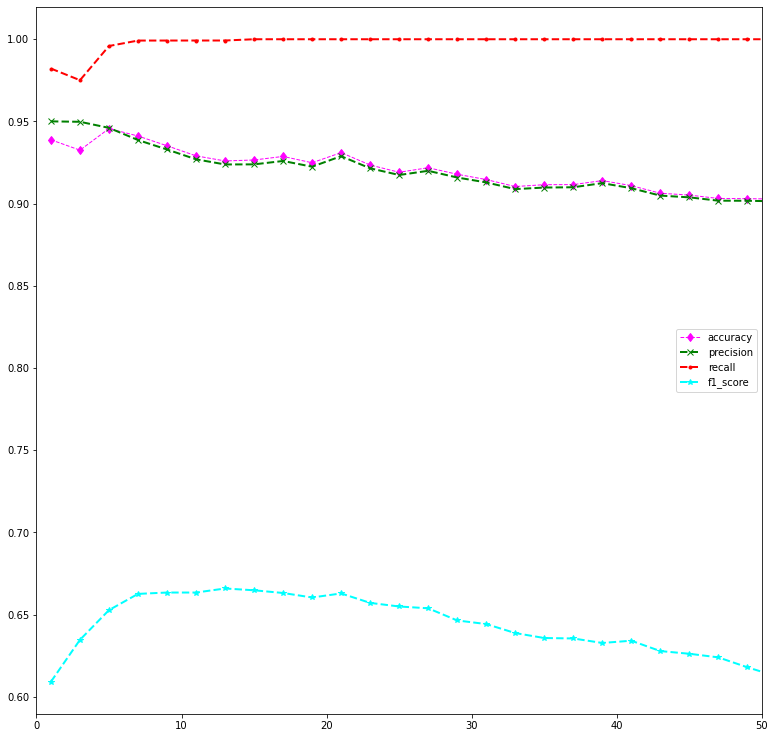

In [ ]:
plt2.figure(figsize=(13,13))

plt2.plot( 'k', 'accuracy', data=results, marker='d', color='magenta', linewidth=1, linestyle='dashed', label="accuracy")
plt2.plot( 'k', 'precision', data=results, marker='x', color='green', linewidth=2, linestyle='dashed', label="precision")
plt2.plot( 'k', 'recall', data=results, marker='.', color='red', linewidth=2, linestyle='dashed', label="recall")
plt2.plot( 'k', 'f1_score', data=results, marker='*', color='cyan', linewidth=2, linestyle='dashed', label="f1_score")
plt2.legend()
plt2.xlim(0,50)
plt2.show()


### **5.3 Training the Model and Generating Confusion Matrix and Classification report**

In [ ]:
#training model with few random values to check the best performance
knnExplore = KNeighborsClassifier(n_neighbors=15)
knnExplore.fit(train_X, train_y)
print("Confusion Matrix:\n",confusion_matrix(valid_y, knnExplore.predict(valid_X)))
print("Classification Matrix:\n",classification_report(valid_y,knnExplore.predict(valid_X),digits=3,zero_division=0 ))

Confusion Matrix:
 [[  51  107   39    0    0    0]
 [   0 1299  248    0    1    0]
 [   0  410  987    0    0    0]
 [   0   38   13   29    0    0]
 [   0  198  142    0   62    0]
 [   0   14   13    0    1    0]]
Classification Matrix:
               precision    recall  f1-score   support

           0      1.000     0.259     0.411       197
           1      0.629     0.839     0.719      1548
           2      0.684     0.707     0.695      1397
           3      1.000     0.362     0.532        80
           4      0.969     0.154     0.266       402
           5      0.000     0.000     0.000        28

    accuracy                          0.665      3652
   macro avg      0.714     0.387     0.437      3652
weighted avg      0.711     0.665     0.634      3652



### **5.4 Randomized Search CV**

In [ ]:
# k-fold classification for KNN using RandomizedSearchCV
k_fold = 10
param_grid = {
    'n_neighbors': list(range(1,59,2)),
}

scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average = 'micro'),
           'recall': make_scorer(recall_score, average = 'micro'),
            }


randomSearch = RandomizedSearchCV(KNeighborsClassifier(), param_grid, cv=k_fold, scoring=scoring,
                          n_jobs=-1,refit='recall')  
randomSearch.fit(train_X, train_y)
print('KNN Randomized Search CV Recall Score: ', randomSearch.best_score_)
print('parameters: ', randomSearch.best_params_)

bestRecallKnn = randomSearch.best_estimator_

KNN Randomized Search CV Recall Score:  0.6623632966222501
parameters:  {'n_neighbors': 9}


### **5.5 Tuning the resulting model using GridSearchCV**

In [ ]:
# k-fold classification for KNN using GridSearchCV
k_fold = 10
param_grid = {
    'n_neighbors': [7,9,11],
}

scoring = {'recall': make_scorer(recall_score, average = 'micro')}


gridSearch = GridSearchCV(KNeighborsClassifier(), param_grid, cv=k_fold, scoring=scoring,
                          n_jobs=-1,refit='recall')  
gridSearch.fit(train_X, train_y)
print('KNN GridSearch CV Recall Score: ', gridSearch.best_score_)
print('parameters: ', gridSearch.best_params_)

bestRecallKnn = gridSearch.best_estimator_

KNN GridSearch CV Recall Score:  0.6623632966222501
parameters:  {'n_neighbors': 9}


##**STEP 6. Decision Tree**




### **6.1 Create an Initial 'wide' Range of Possible Hyperparameter Values for Decision Tree**

In [ ]:
# Create an initial 'wide' range of possible hyperparameter values

# Criterion used to guide data splits
criterion = ['gini', 'entropy']

# Maximum number of levels in tree.
max_depth = [int(x) for x in np.linspace(5, 200, num = 40)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [1, 3, 5, 10, 12, 18]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]

# max_leaf_nodes  - Grow trees with max_leaf_nodes in best-first fashion.
max_leaf_nodes = [None]

# min_impurity_decrease - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
min_impurity_decrease = [0.000, 0.0005, 0.001, 0.005, 0.01]

# Create the random grid
param_grid_random = { 'criterion': criterion,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf' : min_samples_leaf,
                      'max_leaf_nodes' : max_leaf_nodes,
                      'min_impurity_decrease' : min_impurity_decrease,
                     }

### **6.2 Decision Tree Randomize Search CV**

In [ ]:
# Use the param_grid_random for an initial "rough" search using Randomized search
dtree_default = DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
randomSearch = RandomizedSearchCV(estimator = dtree_default, param_distributions = param_grid_random, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
randomSearch.fit(train_X, train_y)
bestRandomModelDT = randomSearch.best_estimator_
print('Best parameters found: ', randomSearch.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.5s finished


Best parameters found:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': None, 'max_depth': 190, 'criterion': 'entropy'}


### **6.3 Test the Random Search CV Performance**

In [ ]:
validation_predictions = bestRandomModelDT.predict(valid_X)
print('Decision Tree model Random Search CV Recall Score:',recall_score(valid_y, validation_predictions, average='micro'))

Decision Tree model Random Search CV Recall Score: 0.9967141292442497


### **6.4 Decision Tree Grid Search CV**

In [ ]:
# Value is picked based on the random search result
param_grid = {
              'min_samples_split': [6, 8, 10, 12, 14],  
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'min_impurity_decrease': [0.0005, 0.001, 0.002, 0.004, 0.006],
              'max_leaf_nodes': [None], 
              'max_depth': [170,180,190,200,210],
              'criterion': ['entropy'],
              }

In [ ]:
dtree_tuned = DecisionTreeClassifier()
gridSearch = GridSearchCV(estimator = dtree_tuned, param_grid=param_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the grid search model
gridSearch.fit(train_X, train_y)
bestGridModelDT = gridSearch.best_estimator_
bestRecallTree=bestGridModelDT
print('Best parameters found: ', gridSearch.best_params_)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed:  2.8min finished


Best parameters found:  {'criterion': 'entropy', 'max_depth': 190, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 8}


### **6.5 Testing the Model performance**

In [ ]:
validation_predictions = bestGridModelDT.predict(valid_X)
print('Decision Tree model Grid Search CV Recall Score:',recall_score(valid_y, validation_predictions,average='micro'))

Decision Tree model Grid Search CV Recall Score: 0.9967141292442497


## **STEP 7. Random Forests**

### **7.1 Create an Initial 'Wide' Range of Possible Hyperparameter Values for Random Forests**

In [ ]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

# Criterion used to guide data splits
criterion = ['gini', 'entropy']

# Maximum number of levels in tree. If None, then nodes are expanded until all leaves are pure or until all 
# leaves contain less than min_samples_split samples.
# default = None
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]

# Number of features to consider at every split
max_features = ['auto']

# max_leaf_nodes
max_leaf_nodes = [None]

# min_impurity_decrease 
min_impurity_decrease = [0.001, 0.005, 0.01, 0.05]

# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
param_grid_random = {'n_estimators': n_estimators,
                      'criterion': criterion,
                      'max_depth': max_depth,
                      'min_samples_split': min_samples_split,
                      'min_samples_leaf' : min_samples_leaf,
                      'max_features': max_features,
                      'max_leaf_nodes' : max_leaf_nodes,
                      'min_impurity_decrease' : min_impurity_decrease,
                      'bootstrap': bootstrap,
                     }

### **7.2 Use Randomize Search to Narrow the Possible Range of Parameter Values**

In [ ]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
randomSearch = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_random, n_iter = 300, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
randomSearch.fit(train_X, train_y)
bestRandomModel = randomSearch.best_estimator_
print('Best parameters found: ', randomSearch.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 25.4min finished


Best parameters found:  {'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': None, 'max_features': 'auto', 'max_depth': 80, 'criterion': 'entropy', 'bootstrap': True}


### **7.3 Test the Performance of Randomized Search CV**

In [ ]:
validation_predictions = bestRandomModel.predict(valid_X)
print('Random Forest Model Randomized Search CV Recall Score: ', recall_score(valid_y, validation_predictions, average='micro'))

Random Forest Model Randomized Search CV Recall Score:  0.9778203723986857


### **7.4 Create a New 'Narrow' Range of Possible Hyperparameter Values bassed on Randomized Search CV**

In [ ]:
param_grid = {'n_estimators': [70, 90, 100, 120, 150],
              'min_samples_split': [3, 5, 7, 10, 12],  
              'min_samples_leaf': [1, 2, 3],
              'min_impurity_decrease': [0.0005, 0.001, 0.0015, 0.002, 0.0025],
              'max_leaf_nodes': [None], 
              'max_features': ['auto'], 
              'max_depth': [50, 70, 80, 100, 120],
              'criterion': ['entropy'],
              'bootstrap': [True]}

### **7.5 Use Grid search CV to Refine Model**

In [ ]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
gridSearch = GridSearchCV(estimator = rf, param_grid=param_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the random search model
gridSearch.fit(train_X, train_y)
bestGridModel = gridSearch.best_estimator_
print('Best parameters found: ', gridSearch.best_params_)

Fitting 3 folds for each of 1875 candidates, totalling 5625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done 3277 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 4897 tasks      | elapsed: 55.9min
[Parallel(n_jobs=-1)]: Done 5625 out of 5625 | elapsed: 63.0min finished


Best parameters found:  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 80, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 70}


### **7.6 Test the performance of the model using identified parameters**

In [ ]:
validation_predictions = bestGridModel.predict(valid_X)
print('Random Forest Model Grid Search CV Recall Score:',recall_score(valid_y, validation_predictions,average='micro'))

Random Forest Model Grid Search CV Recall Score: 0.9849397590361446


## **STEP 8. Best Model and Plot**

### **8.1 Because decision tree model performs the best, I choose to plot that model.**

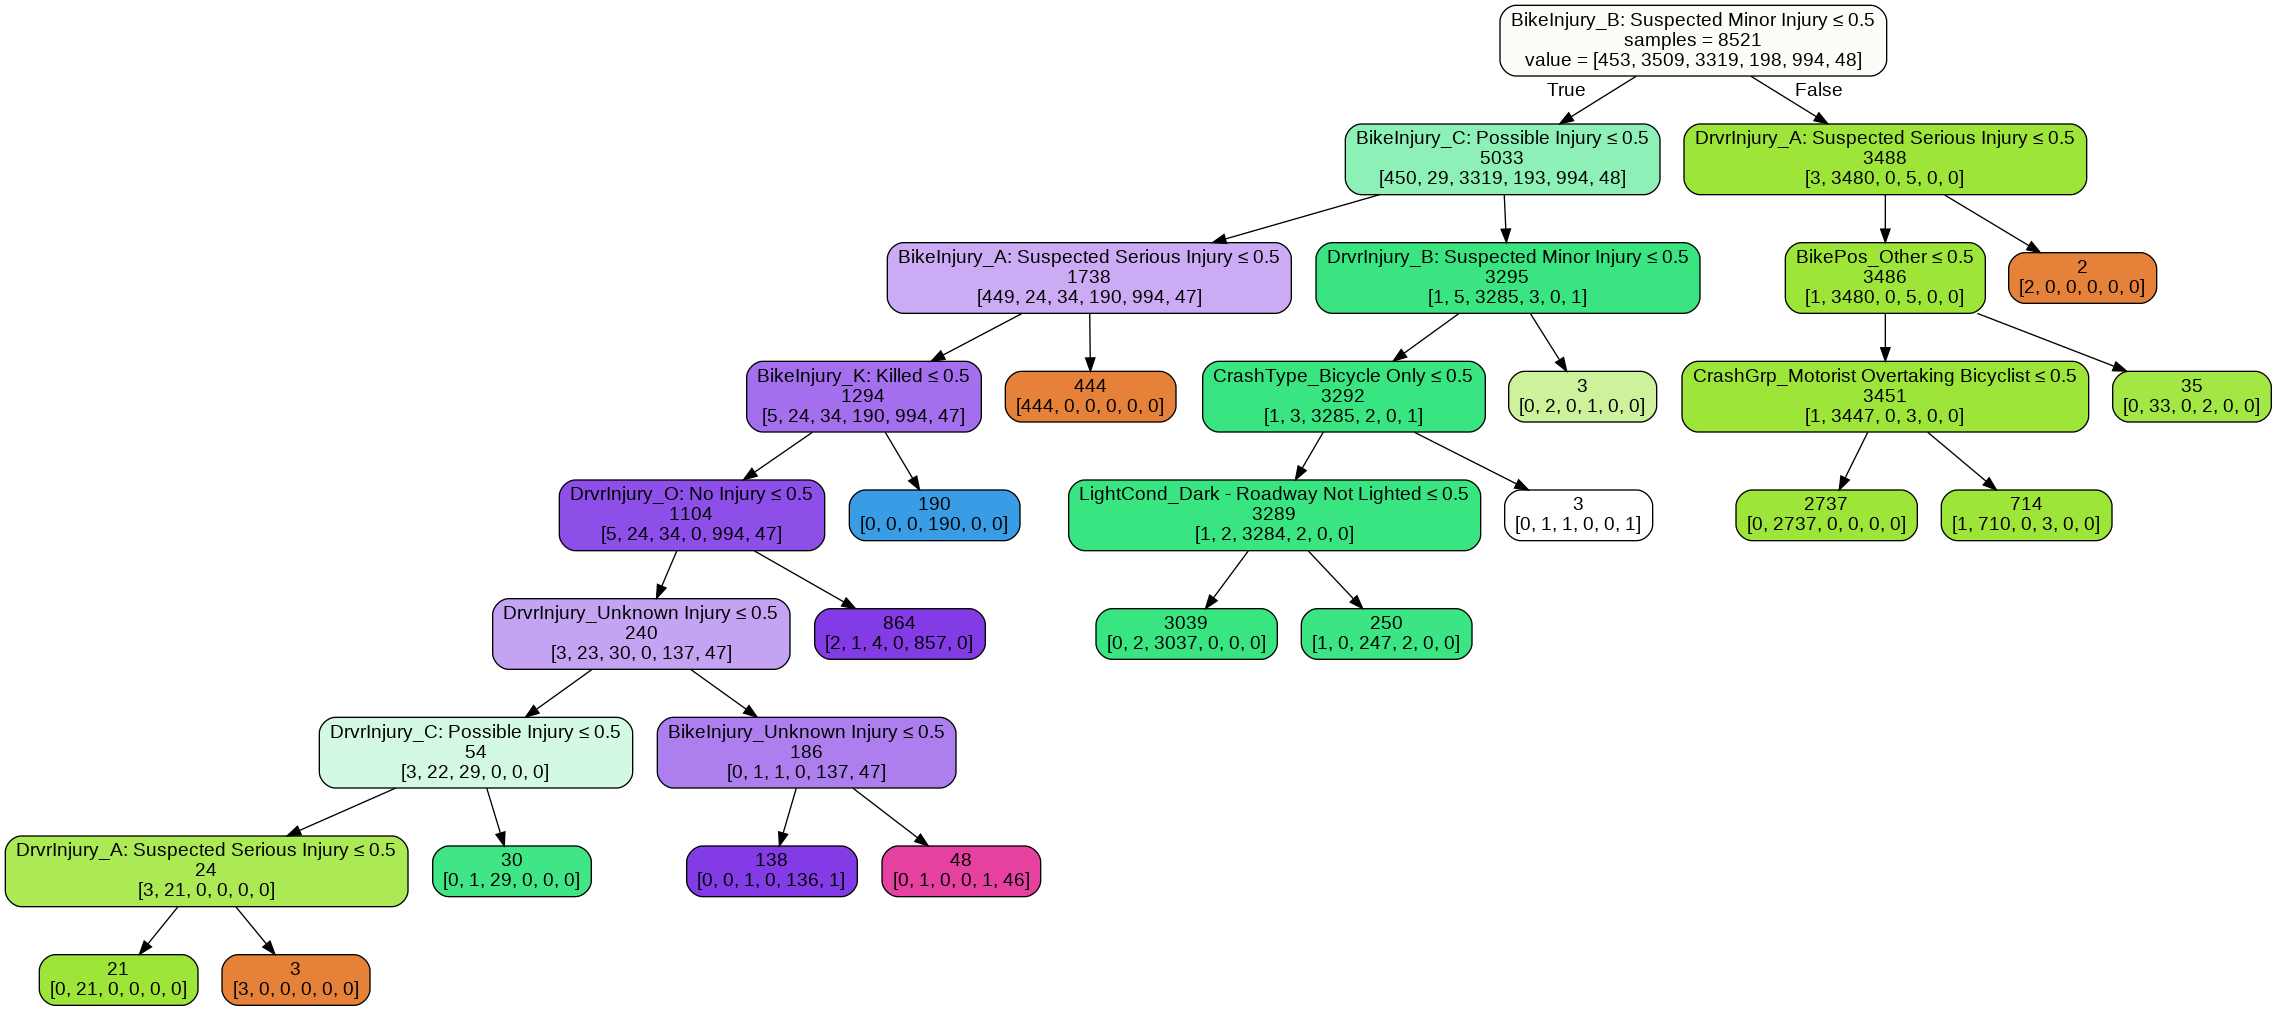

In [ ]:
plotDecisionTree(bestRecallTree, feature_names=train_X.columns)

### **8.2 Refine and Rerun**

The biker injury and driver injury dominates the model. Since they are rather evident influences, we remove it from our predictors and rerun the decision tree grid search CV model. After rerun it, we found that "AmbulanceR" is another dominator. As we know "AmbulanceR" is an evident influence, we remove and rerun again.

In [ ]:
train_X.drop(columns=['BikeInjury_A: Suspected Serious Injury', 'BikeInjury_B: Suspected Minor Injury',
       'BikeInjury_C: Possible Injury', 'BikeInjury_K: Killed','BikeInjury_O: No Injury',
       'BikeInjury_Unknown Injury','DrvrInjury_A: Suspected Serious Injury',
       'DrvrInjury_B: Suspected Minor Injury', 'DrvrInjury_C: Possible Injury',
       'DrvrInjury_K: Killed', 'DrvrInjury_O: No Injury','AmbulanceR',
       'DrvrInjury_Unknown Injury'],inplace=True)
train_X

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,BikeAlcFlg,CrashAlcoh,CrashDay,CrashMonth,DrvrAlcFlg,SpeedLimit,HitRun,NumLanes,BikeAge,CrashHour,DrvrAge,CrashYear,CrashLoc_Intersection,CrashLoc_Intersection-Related,CrashLoc_Non-Intersection,CrashLoc_Non-Roadway,CrashLoc_Unknown Location,CrashType_Backing Vehicle,CrashType_Backing Vehicle,CrashType_Bicycle Only,CrashType_Bicycle Only,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Multiple Threat,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Trapped,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Failed to Clear - Unknown,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Intentionally Caused,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Opposite Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Left Turn - Same Direction,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Alcohol / Drug Impairment,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Mechanical Problems,CrashType_Bicyclist Lost Control - Other / Unknown,CrashType_Bicyclist Lost Control - Other / Unknown,"CrashType_Bicyclist Lost Control - Oversteering, Improper Braking, Speed",...,RdSurface_Unknown,Region_Coastal,Region_Mountains,Region_Piedmont,RuralUrban_.,RuralUrban_Rural,RuralUrban_Urban,"TraffCntrl_Double Yellow Line, No Passing Zone",TraffCntrl_Flashing Signal With Stop Sign,TraffCntrl_Flashing Signal Without Stop Sign,TraffCntrl_Flashing Stop And Go Signal,TraffCntrl_Human Control,TraffCntrl_Missing,TraffCntrl_No Control Present,TraffCntrl_Other,TraffCntrl_RR Gate And Flasher,TraffCntrl_School Zone Signs,TraffCntrl_Stop And Go Signal,TraffCntrl_Stop Sign,TraffCntrl_Warning Sign,TraffCntrl_Yield Sign,RdDefects_Debris,RdDefects_Missing,RdDefects_No Shoulders,RdDefects_Non-Highway Work,RdDefects_None,RdDefects_Obstruction In Roadway,RdDefects_Other,RdDefects_Road Surface Condition,"RdDefects_Rut, Holes, Bumps","RdDefects_Shoulders Low, Soft Or High","RdDefects_Traffic Control Device Inoperative, Not Visible Or Missing",RdDefects_Unknown,RdDefects_Work Zone,Weather_Clear,Weather_Cloudy,"Weather_Fog, Smog, Smoke",Weather_Other,Weather_Rain,"Weather_Snow, Sleet, Hail, Freezing Rain/Drizzle"
5650,1,0,0,9,1,1,0,2,54.0,15,59.0,2012,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
116,1,0,6,7,1,1,0,3,12.0,16,49.0,2007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2167,1,0,0,8,1,2,0,1,48.0,11,61.0,2009,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8855,1,0,0,6,1,1,0,3,33.0,21,38.0,2015,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8982,1,0,4,1,0,1,1,3,16.0,15,45.0,2015,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,1,0,2,3,1,0,0,1,29.0,15,40.0,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
10955,1,0,0,1,1,2,0,1,27.0,7,20.0,2018,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
905,3,1,4,9,1,2,0,1,37.0,14,53.0,2007,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1875 out of 1875 | elapsed:  5.0min finished


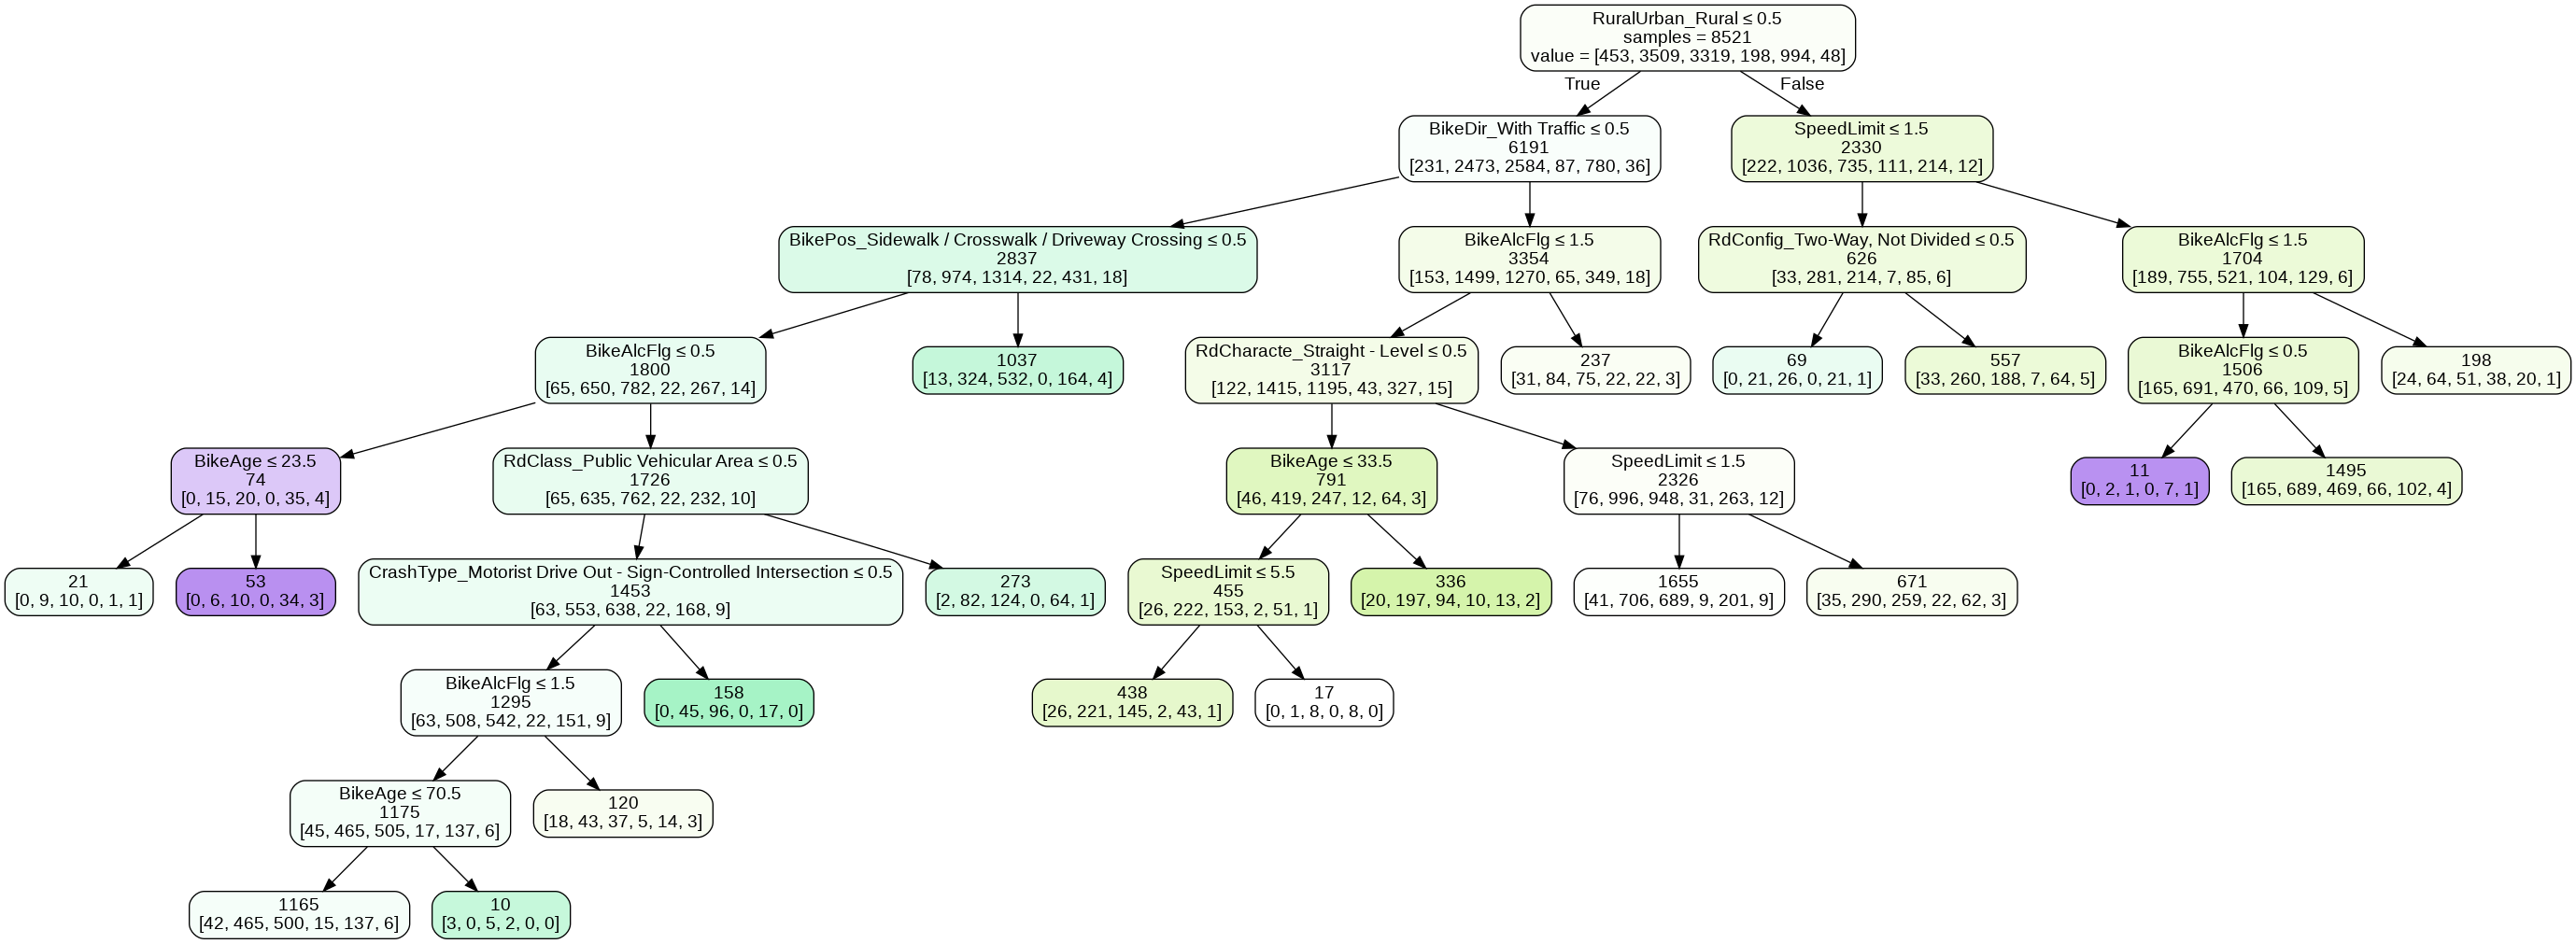

In [ ]:
# Rerun Grid Search CV Decision Tree
param_grid = {
              'min_samples_split': [6, 8, 10, 12, 14],  
              'min_samples_leaf': [1, 2, 3, 4, 5],
              'min_impurity_decrease': [0.0005, 0.001, 0.002, 0.004, 0.006],
              'max_leaf_nodes': [None], 
              'max_depth': [170,180,190,200,210],
              'criterion': ['entropy'],
              }
dtree_tuned = DecisionTreeClassifier()
gridSearch = GridSearchCV(estimator = dtree_tuned, param_grid=param_grid, cv = 3, verbose=2,  n_jobs = -1)
# Fit the grid search model
gridSearch.fit(train_X, train_y)
bestGridModelDT2 = gridSearch.best_estimator_
bestRecallTree2=bestGridModelDT2

plotDecisionTree(bestRecallTree2, feature_names=train_X.columns)

### **8.3 Feature of Importance**

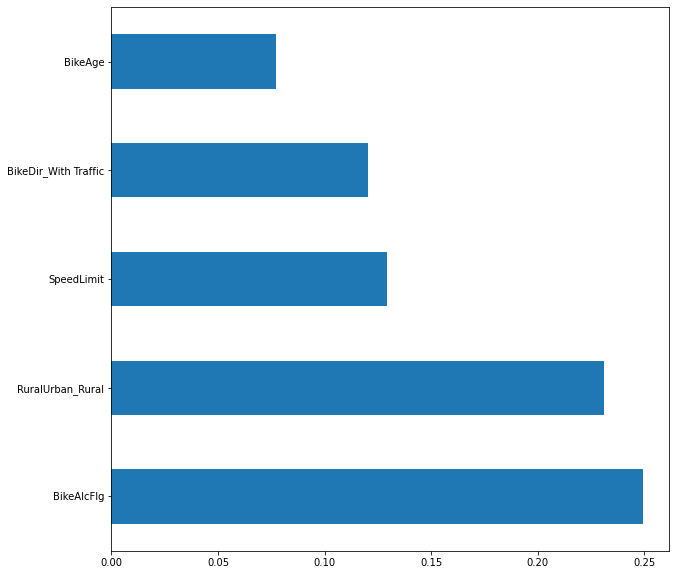

In [ ]:
feat_importances = pd.Series(bestRecallTree2.feature_importances_,index=train_X.columns)
feat_importances.nlargest(5).plot(kind='barh',figsize=(10,10))


## **STEP 9. Discussion**

We based the performnance of the model on the recall score because there is a high cost associated with false negative, meaning the ability of the model to perform well can help save lives or cause deaths. For instance, classifying a serious injury as a minor injury could be desastrous since bikers suffering from serious injuries are more likely to die and require more attention than patients with minor injuries. If the injury is serious for example, it will require calling ambulance and going to the hospital right away while a minor injury does not require ambulance. 

We provide the various recall scores below based on each model used and provide our recommendation while taking into account the model that has the best recall score. 

### **Recall Score Comparison**
**Naive Bayes Randomized Search CV**  Recall Score:

0.8644578313253012

**Naive Bayes Grid Search CV**  Recall Score: 

0.8650054764512596

**KNN Randomized Search CV**  Recall Score: 

0.6623632966222501

**KNN GridSearch CV**  Recall Score:  

0.6623632966222501

**Decision Tree model** **Random Search CV** Recall Score: 

**0.9969879518072289**

**Decision Tree model Grid Search CV** Recall Score: 

**0.9969879518072289**

**Random Forest Model Randomized Search CV** Recall Score:  

0.9778203723986857


**Random Forest Model Grid Search CV** Recall Score: 

0.9849397590361446

According to the recall score, the best model is: **decision tree**

---

### **Best Model's Parameter**

**Decision Tree Grid Search CV** Parameter:

'criterion': 'entropy', 

'max_depth': 190,

'max_leaf_nodes': None, 

'min_impurity_decrease': 0.001,

'min_samples_leaf': 2,

'min_samples_split': 8
